# Problem 3:
Finding the coins

In [1]:
# imports
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

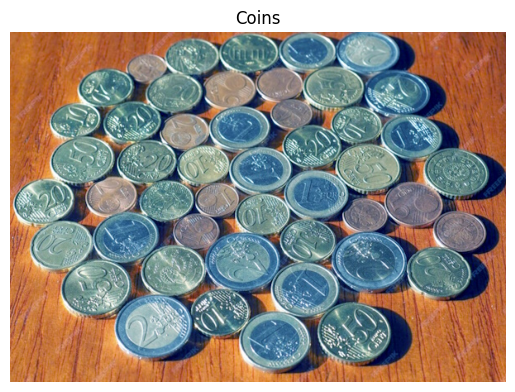

In [2]:
# open the image
coins_image_path = os.path.join('imgs', 'coins2.jpg')
coins_image = cv2.imread(coins_image_path)

# display the image (using matplotlib here cause was having issues with the cv3 imshow on macos)
coins_image_rgb = cv2.cvtColor(coins_image, cv2.COLOR_BGR2RGB)
plt.imshow(coins_image_rgb)
plt.title('Coins')
plt.axis('off')
plt.show()


In [3]:
# Interactive perspective warp tuner for the coins image
# Lets you push trapezoid corners outside the image bounds and auto-expands
# the output canvas so no source pixels are cropped (blank borders are OK).
#
# If the controls do not feel interactive in your notebook, run this once first:
# %matplotlib widget

import ipywidgets as widgets
from IPython.display import display, clear_output

h_img, w_img = coins_image.shape[:2]


def warp_with_auto_canvas(image, pts_src, rect_w, rect_h, pad=20):
    """Warp image with automatic output translation/expansion to avoid cropping."""
    pts_src = np.asarray(pts_src, dtype=np.float32)
    pts_dst = np.float32([
        [0, 0],
        [rect_w - 1, 0],
        [0, rect_h - 1],
        [rect_w - 1, rect_h - 1]
    ])

    # Base perspective transform (user trapezoid -> ideal rectangle)
    H_base = cv2.getPerspectiveTransform(pts_src, pts_dst)

    # Find where the full source image corners land after the base warp.
    src_corners = np.float32([
        [0, 0],
        [w_img - 1, 0],
        [w_img - 1, h_img - 1],
        [0, h_img - 1]
    ]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(src_corners, H_base).reshape(-1, 2)

    min_xy = np.floor(warped_corners.min(axis=0) - pad)
    max_xy = np.ceil(warped_corners.max(axis=0) + pad)

    out_w = max(1, int(max_xy[0] - min_xy[0]))
    out_h = max(1, int(max_xy[1] - min_xy[1]))

    # Translate so every mapped source pixel is inside the output canvas.
    T = np.array([
        [1, 0, -min_xy[0]],
        [0, 1, -min_xy[1]],
        [0, 0, 1]
    ], dtype=np.float32)
    H_full = T @ H_base

    warped = cv2.warpPerspective(
        image,
        H_full,
        (out_w, out_h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0)
    )

    return H_base, H_full, pts_dst, warped, warped_corners, (out_w, out_h)


def run_hough_preview(warped_bgr):
    """Run the same HoughCircles pipeline you already had (for live preview)."""
    img_gray = cv2.cvtColor(warped_bgr, cv2.COLOR_BGR2GRAY)
    img_grayb = cv2.GaussianBlur(img_gray, (9, 9), 2)

    circles = cv2.HoughCircles(
        img_grayb,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=40,
        param1=50,
        param2=20,
        minRadius=20,
        maxRadius=40
    )

    hough_image = warped_bgr.copy()
    circles_num = 0

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for x_coor, y_coor, detected_radius in circles[0]:
            cv2.circle(hough_image, (x_coor, y_coor), detected_radius, (0, 0, 255), 2)
            cv2.circle(hough_image, (x_coor, y_coor), 2, (0, 255, 0), 3)
            circles_num += 1

    return hough_image, circles_num


def draw_src_overlay(image, pts_src):
    disp = image.copy()
    pts_int = np.int32(np.round(pts_src)).reshape((-1, 1, 2))
    cv2.polylines(disp, [pts_int], isClosed=True, color=(0, 255, 0), thickness=2)

    labels = ['TL', 'TR', 'BL', 'BR']
    for label, pt in zip(labels, pts_src):
        x, y = int(round(pt[0])), int(round(pt[1]))
        cv2.circle(disp, (x, y), 6, (0, 0, 255), -1)
        cv2.putText(disp, label, (x + 8, y - 8), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 0), 1, cv2.LINE_AA)
    return disp


# Slider ranges intentionally allow points outside the image.
x_min, x_max = -400, w_img + 400
y_min, y_max = -250, h_img + 250

controls = {
    'tl_x': widgets.IntSlider(value=100, min=x_min, max=x_max, step=1, description='TL x'),
    'tl_y': widgets.IntSlider(value=0, min=y_min, max=y_max, step=1, description='TL y'),
    'tr_x': widgets.IntSlider(value=500, min=x_min, max=x_max, step=1, description='TR x'),
    'tr_y': widgets.IntSlider(value=0, min=y_min, max=y_max, step=1, description='TR y'),
    'bl_x': widgets.IntSlider(value=0, min=x_min, max=x_max, step=1, description='BL x'),
    'bl_y': widgets.IntSlider(value=h_img, min=y_min, max=y_max, step=1, description='BL y'),
    'br_x': widgets.IntSlider(value=w_img, min=x_min, max=x_max, step=1, description='BR x'),
    'br_y': widgets.IntSlider(value=h_img, min=y_min, max=y_max, step=1, description='BR y'),
    'rect_w': widgets.IntSlider(value=600, min=300, max=1400, step=10, description='Rect W'),
    'rect_h': widgets.IntSlider(value=600, min=300, max=1400, step=10, description='Rect H'),
    'pad': widgets.IntSlider(value=20, min=0, max=200, step=5, description='Pad'),
    'show_hough': widgets.Checkbox(value=True, description='Show Hough preview'),
}

for w in controls.values():
    if hasattr(w, 'continuous_update'):
        w.continuous_update = False

plot_out = widgets.Output()
text_out = widgets.Output()
print_btn = widgets.Button(description='Print current warp values', button_style='')


def current_pts():
    return np.float32([
        [controls['tl_x'].value, controls['tl_y'].value],
        [controls['tr_x'].value, controls['tr_y'].value],
        [controls['bl_x'].value, controls['bl_y'].value],
        [controls['br_x'].value, controls['br_y'].value],
    ])


def refresh(*_):
    pts_src_local = current_pts()
    rect_w = controls['rect_w'].value
    rect_h = controls['rect_h'].value
    pad = controls['pad'].value

    with plot_out:
        clear_output(wait=True)
        try:
            H_base, H_full, pts_dst, warped_local, warped_corners, out_size = warp_with_auto_canvas(
                coins_image, pts_src_local, rect_w, rect_h, pad=pad
            )
            original_overlay = draw_src_overlay(coins_image, pts_src_local)

            if controls['show_hough'].value:
                hough_local, circles_num = run_hough_preview(warped_local)
            else:
                hough_local, circles_num = warped_local.copy(), None

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))

            axes[0].imshow(cv2.cvtColor(original_overlay, cv2.COLOR_BGR2RGB))
            axes[0].set_title('Original + Adjustable Trapezoid')
            axes[0].axis('off')

            axes[1].imshow(cv2.cvtColor(warped_local, cv2.COLOR_BGR2RGB))
            axes[1].set_title(f'Warped (auto canvas {out_size[0]}x{out_size[1]})')
            axes[1].axis('off')

            axes[2].imshow(cv2.cvtColor(hough_local, cv2.COLOR_BGR2RGB))
            if circles_num is None:
                axes[2].set_title('Warped Preview')
            else:
                axes[2].set_title(f'Warped + Hough Circles (count={circles_num})')
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            # Export values back to notebook namespace for later cells.
            globals()['pts_src'] = pts_src_local
            globals()['pts_dst'] = pts_dst
            globals()['warp_w'] = rect_w
            globals()['warp_h'] = rect_h
            globals()['matrix_base'] = H_base
            globals()['matrix'] = H_full   # matrix actually used by cv2.warpPerspective
            globals()['warped_coins_image'] = warped_local
            globals()['hough_image'] = hough_local

            with text_out:
                clear_output(wait=True)
                print(f'Output canvas: {out_size[0]} x {out_size[1]}')
                print('Tip: push BL/BR x beyond image width (negative / >600) for stronger bottom stretch.')
                if circles_num is not None:
                    print(f'Number of Hough circles: {circles_num}')

        except cv2.error as e:
            print(f'OpenCV error (likely degenerate point layout): {e}')
        except Exception as e:
            print(f'Error: {e}')


def print_current(_):
    pts = current_pts()
    with text_out:
        clear_output(wait=True)
        print('Copy these values into a non-interactive cell if you want a fixed solution:')
        print('pts_src = np.float32([')
        for p in pts:
            print(f'    [{p[0]:.0f}, {p[1]:.0f}],')
        print('])')
        print(f"warp_w, warp_h = {controls['rect_w'].value}, {controls['rect_h'].value}")
        print(f"pad = {controls['pad'].value}")


print_btn.on_click(print_current)
for w in controls.values():
    w.observe(refresh, names='value')

left_col = widgets.VBox([
    widgets.HTML('<b>Trapezoid source points (can be outside image)</b>'),
    widgets.HBox([controls['tl_x'], controls['tl_y']]),
    widgets.HBox([controls['tr_x'], controls['tr_y']]),
    widgets.HBox([controls['bl_x'], controls['bl_y']]),
    widgets.HBox([controls['br_x'], controls['br_y']]),
])

right_col = widgets.VBox([
    widgets.HTML('<b>Warp output</b>'),
    controls['rect_w'],
    controls['rect_h'],
    controls['pad'],
    controls['show_hough'],
    print_btn,
    text_out,
])

ui = widgets.VBox([
    widgets.HBox([left_col, right_col]),
    plot_out,
])

display(ui)
refresh()



In [6]:
# Fixed warp (from your chosen settings) + interactive Hough tuning
# Pipeline:
# 1) Warp image to improve circle geometry
# 2) Run HoughCircles on warped image with interactive parameters
# 3) Map detected circles back to original perspective (distorted contours)

import ipywidgets as widgets
from IPython.display import display, clear_output

# Your chosen warp settings
pts_src = np.float32([
    [200, 0],
    [400, 0],
    [0, 423],
    [600, 423],
])
warp_w, warp_h = 690, 1280
pad = 20

h_img, w_img = coins_image.shape[:2]


def warp_with_auto_canvas_fixed(image, pts_src, rect_w, rect_h, pad=0):
    pts_src = np.asarray(pts_src, dtype=np.float32)
    pts_dst = np.float32([
        [0, 0],
        [rect_w - 1, 0],
        [0, rect_h - 1],
        [rect_w - 1, rect_h - 1],
    ])

    H_base = cv2.getPerspectiveTransform(pts_src, pts_dst)

    src_corners = np.float32([
        [0, 0],
        [w_img - 1, 0],
        [w_img - 1, h_img - 1],
        [0, h_img - 1],
    ]).reshape(-1, 1, 2)

    warped_corners = cv2.perspectiveTransform(src_corners, H_base).reshape(-1, 2)
    min_xy = np.floor(warped_corners.min(axis=0) - pad)
    max_xy = np.ceil(warped_corners.max(axis=0) + pad)

    out_w = max(1, int(max_xy[0] - min_xy[0]))
    out_h = max(1, int(max_xy[1] - min_xy[1]))

    T = np.array([
        [1, 0, -min_xy[0]],
        [0, 1, -min_xy[1]],
        [0, 0, 1],
    ], dtype=np.float32)

    H_full = T @ H_base  # original -> warped canvas
    H_inv = np.linalg.inv(H_full).astype(np.float32)  # warped canvas -> original

    warped = cv2.warpPerspective(
        image,
        H_full,
        (out_w, out_h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )

    return {
        'warped': warped,
        'H_full': H_full.astype(np.float32),
        'H_inv': H_inv,
        'H_base': H_base.astype(np.float32),
        'pts_dst': pts_dst,
        'out_size': (out_w, out_h),
        'warped_corners': warped_corners,
    }


def draw_trapezoid_overlay(image, pts_src):
    out = image.copy()
    pts_int = np.int32(np.round(pts_src)).reshape(-1, 1, 2)
    cv2.polylines(out, [pts_int], True, (0, 255, 0), 2)
    for label, pt in zip(['TL', 'TR', 'BL', 'BR'], pts_src):
        x, y = int(round(pt[0])), int(round(pt[1]))
        cv2.circle(out, (x, y), 5, (0, 0, 255), -1)
        cv2.putText(out, label, (x + 6, y - 6), cv2.FONT_HERSHEY_SIMPLEX,
                    0.45, (255, 255, 0), 1, cv2.LINE_AA)
    return out


def detect_hough_circles(img_bgr, dp, min_dist, param1, param2, min_radius, max_radius,
                         blur_k=9, blur_sigma=2.0):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur_k = max(1, int(blur_k))
    if blur_k % 2 == 0:
        blur_k += 1
    gray_blur = cv2.GaussianBlur(gray, (blur_k, blur_k), blur_sigma)

    circles = cv2.HoughCircles(
        gray_blur,
        cv2.HOUGH_GRADIENT,
        dp=float(dp),
        minDist=float(min_dist),
        param1=float(param1),
        param2=float(param2),
        minRadius=int(min_radius),
        maxRadius=int(max_radius),
    )
    return gray_blur, circles


def circle_contour_backproject(circle_xyr, H_inv, samples=120):
    x, y, r = [float(v) for v in circle_xyr]
    theta = np.linspace(0, 2 * np.pi, samples, endpoint=False, dtype=np.float32)
    pts = np.stack([
        x + r * np.cos(theta),
        y + r * np.sin(theta)
    ], axis=1).astype(np.float32).reshape(-1, 1, 2)

    pts_orig = cv2.perspectiveTransform(pts, H_inv).reshape(-1, 2)
    center_orig = cv2.perspectiveTransform(
        np.array([[[x, y]]], dtype=np.float32), H_inv
    ).reshape(2)

    return pts_orig, center_orig


# Precompute the fixed warp once (interactive Hough tuning reuses it)
warp_fixed = warp_with_auto_canvas_fixed(
    coins_image,
    pts_src_fixed,
    warp_w_fixed,
    warp_h_fixed,
    pad=pad_fixed,
)
warped_fixed = warp_fixed['warped']
H_inv_fixed = warp_fixed['H_inv']

# Controls for Hough parameters
hough_controls = {
    'dp': widgets.FloatSlider(value=1.0, min=1.0, max=3.0, step=0.1, description='dp'),
    'minDist': widgets.IntSlider(value=40, min=5, max=200, step=1, description='minDist'),
    'param1': widgets.IntSlider(value=50, min=1, max=300, step=1, description='param1'),
    'param2': widgets.IntSlider(value=20, min=1, max=100, step=1, description='param2'),
    'minRadius': widgets.IntSlider(value=20, min=1, max=200, step=1, description='minR'),
    'maxRadius': widgets.IntSlider(value=40, min=1, max=300, step=1, description='maxR'),
    'blur_k': widgets.IntSlider(value=9, min=1, max=21, step=2, description='blur k'),
    'blur_sigma': widgets.FloatSlider(value=2.0, min=0.0, max=5.0, step=0.1, description='sigma'),
    'samples': widgets.IntSlider(value=120, min=24, max=360, step=12, description='contour pts'),
    'show_labels': widgets.Checkbox(value=False, description='Label circles'),
}
for w in hough_controls.values():
    if hasattr(w, 'continuous_update'):
        w.continuous_update = False

hough_plot_out = widgets.Output()
hough_text_out = widgets.Output()
print_hough_btn = widgets.Button(description='Print current Hough params')


def draw_results(*_):
    min_r = hough_controls['minRadius'].value
    max_r = hough_controls['maxRadius'].value
    if min_r > max_r:
        with hough_text_out:
            clear_output(wait=True)
            print('minRadius must be <= maxRadius')
        return

    gray_blur, circles = detect_hough_circles(
        warped_fixed,
        dp=hough_controls['dp'].value,
        min_dist=hough_controls['minDist'].value,
        param1=hough_controls['param1'].value,
        param2=hough_controls['param2'].value,
        min_radius=min_r,
        max_radius=max_r,
        blur_k=hough_controls['blur_k'].value,
        blur_sigma=hough_controls['blur_sigma'].value,
    )

    warped_overlay = warped_fixed.copy()
    original_backproj = draw_trapezoid_overlay(coins_image, pts_src_fixed)

    circles_float = []
    if circles is not None:
        circles_float = circles[0].astype(np.float32)

    for idx, (x, y, r) in enumerate(circles_float, start=1):
        # Draw circle in warped view (true circle there)
        cv2.circle(warped_overlay, (int(round(x)), int(round(y))), int(round(r)), (0, 0, 255), 2)
        cv2.circle(warped_overlay, (int(round(x)), int(round(y))), 2, (0, 255, 0), 3)

        # Back-project circle contour to original perspective (generally not a circle)
        contour_orig_f, center_orig_f = circle_contour_backproject(
            (x, y, r), H_inv_fixed, samples=hough_controls['samples'].value
        )

        contour_orig = np.int32(np.round(contour_orig_f)).reshape(-1, 1, 2)
        cv2.polylines(original_backproj, [contour_orig], True, (255, 0, 255), 2)

        cx0, cy0 = int(round(center_orig_f[0])), int(round(center_orig_f[1]))
        cv2.circle(original_backproj, (cx0, cy0), 2, (0, 255, 255), 3)

        if hough_controls['show_labels'].value:
            cv2.putText(original_backproj, str(idx), (cx0 + 4, cy0 - 4),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1, cv2.LINE_AA)

    with hough_plot_out:
        clear_output(wait=True)
        fig, axes = plt.subplots(1, 4, figsize=(22, 6))

        axes[0].imshow(cv2.cvtColor(draw_trapezoid_overlay(coins_image, pts_src_fixed), cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original + Fixed Trapezoid')
        axes[0].axis('off')

        axes[1].imshow(cv2.cvtColor(warped_fixed, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'Warped (fixed) {warp_fixed["out_size"][0]}x{warp_fixed["out_size"][1]}')
        axes[1].axis('off')

        axes[2].imshow(gray_blur, cmap='gray')
        axes[2].set_title('Blurred Gray (Hough input)')
        axes[2].axis('off')

        axes[3].imshow(cv2.cvtColor(warped_overlay, cv2.COLOR_BGR2RGB))
        axes[3].set_title(f'Warped + Hough (count={len(circles_float)})')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(original_backproj, cv2.COLOR_BGR2RGB))
        plt.title('Detected circles back-projected to original perspective')
        plt.axis('off')
        plt.show()

    with hough_text_out:
        clear_output(wait=True)
        print(f'Warped canvas size: {warp_fixed["out_size"][0]} x {warp_fixed["out_size"][1]}')
        print(f'Detected circles: {len(circles_float)}')
        print('Back-projected outlines are perspective-distorted circle contours (expected).')

    # Export useful variables for later notebook cells
    globals()['pts_src'] = pts_src_fixed
    globals()['warp_w'] = warp_w_fixed
    globals()['warp_h'] = warp_h_fixed
    globals()['pad'] = pad_fixed
    globals()['warped_coins_image'] = warped_fixed
    globals()['matrix'] = warp_fixed['H_full']
    globals()['matrix_inv'] = H_inv_fixed
    globals()['hough_circles_warped'] = np.array(circles_float, dtype=np.float32) if len(circles_float) else None
    globals()['hough_backprojected_image'] = original_backproj
    globals()['hough_warped_overlay_image'] = warped_overlay


def print_hough_params(_):
    with hough_text_out:
        clear_output(wait=True)
        print('Current Hough params (copy into a non-interactive cell):')
        print(f"dp = {hough_controls['dp'].value:.1f}")
        print(f"minDist = {hough_controls['minDist'].value}")
        print(f"param1 = {hough_controls['param1'].value}")
        print(f"param2 = {hough_controls['param2'].value}")
        print(f"minRadius = {hough_controls['minRadius'].value}")
        print(f"maxRadius = {hough_controls['maxRadius'].value}")
        print(f"blur_k = {hough_controls['blur_k'].value}")
        print(f"blur_sigma = {hough_controls['blur_sigma'].value:.1f}")
        print(f"contour_samples = {hough_controls['samples'].value}")


print_hough_btn.on_click(print_hough_params)
for w in hough_controls.values():
    w.observe(draw_results, names='value')

hough_ui = widgets.VBox([
    widgets.HTML('<b>Interactive HoughCircles tuning on fixed warped image</b>'),
    widgets.HBox([
        widgets.VBox([
            hough_controls['dp'],
            hough_controls['minDist'],
            hough_controls['param1'],
            hough_controls['param2'],
            hough_controls['minRadius'],
            hough_controls['maxRadius'],
        ]),
        widgets.VBox([
            hough_controls['blur_k'],
            hough_controls['blur_sigma'],
            hough_controls['samples'],
            hough_controls['show_labels'],
            print_hough_btn,
            hough_text_out,
        ]),
    ]),
    hough_plot_out,
])

display(hough_ui)
draw_results()

